# My cats and dogs images classifyer

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


## Let's see if there is a GPU available

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Loading the data in
In here i have defined a few transforms that will be applied to both training and test sets, and dome only to the training set.
All the transforms are self explanatory

In [4]:
train_dir = 'Cat_Dog_data/train'
test_dir = 'Cat_Dog_data/test'

train_transform = transforms.Compose([transforms.Resize(64),
                                transforms.RandomResizedCrop(64),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

test_transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In her we separate out training set into trainset and validation set
we fist define a the persentage of our trainning set we want our validation set to be 
then we make use of the sampler "SubsetRandomSampler()" from "torch.utils.data.sampler"

In [5]:
# seting the persentage of the validation size th 20%
val_size = 0.2
batch_size = 32
# obtain training indices that will be used for validation
len_train_set = len(train_data)

# create a list that will hold all the indeces of the trainning dataset and shuffle this list
indices = list(range(len_train_set))
np.random.shuffle(indices)

# np.floor(a) ---> gives the smalest int value closest to a
split = int(np.floor(val_size * len_train_set))

# isn't this beautiful... God!!! I love python 
train_idx, val_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [6]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True)

In [7]:
# specify the image classes
classes = ["Cat", "Dog"]

## Let's visualize the data we imported

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

tensor(1)


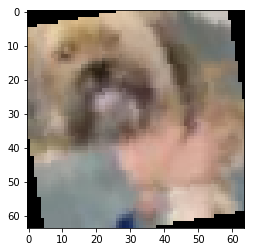

In [8]:
images, lables = next(iter(train_loader))
img_idx = 10
img = images[img_idx]

imshow(img)
img.shape
print(lables[img_idx])

# Defining our Networks Archtecture

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
            # convolutions
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)

        # Max-pool
        self.pool = nn.MaxPool2d(2,2)

        # Dropout
        self.dropout = nn.Dropout(p=0.3)
        # Linear Layer
        self.fc1 = nn.Linear(8*8*64,512)
        self.fc2 = nn.Linear(512,512)

        # output
        self.out = nn.Linear(512,2)


    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1,8*8*64)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        x = self.out(x)
        #x = torch.sigmoid(x)
        x = F.log_softmax(x, dim=1)
        return x


model =  Classifier()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
)


## Specify loss function and optimizer

In [12]:
import torch.optim as optim

# specify loss function
criterion = nn.NLLLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training the Network

In [13]:
epochs = 15
train_losses, valid_losses, test_losses = [], [], []

In [137]:
# number of epochs to train the model
import time

print("Training started...")

valid_loss_min = np.Inf # track change in validation loss and we make it infinity to see it go down

for e in range(1, epochs+1):
    tic = time.time()
    # keep track of training and validation loss per bathc
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        # I don't get why we have to multiply by batch size "*images.size(0)"
        train_loss += loss.item()*images.size(0)
        #train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    
    print("Validating the model")
    
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        
        
        valid_loss += loss.item()*images.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_losses.append(train_loss)    
    valid_losses.append(valid_loss)
    # print training and validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(valid_loss_min, valid_loss))
        
        torch.save(model.state_dict(), '/Model states/model_cat_and_dog2.pt')
        
        valid_loss_min = valid_loss
        
    toc = time.time()
    print(str((toc - tic) * 1000) + "ms")

Training started...
Validating the model
Epoch: 1 	Training Loss: 0.532483 	Validation Loss: 0.124038
Validation loss decreased (inf --> 0.124038).  Saving model ...
789507.8361034393ms
Validating the model
Epoch: 2 	Training Loss: 0.490507 	Validation Loss: 0.118168
Validation loss decreased (0.124038 --> 0.118168).  Saving model ...
408351.75824165344ms
Validating the model
Epoch: 3 	Training Loss: 0.473053 	Validation Loss: 0.111267
Validation loss decreased (0.118168 --> 0.111267).  Saving model ...
407654.88839149475ms
Validating the model
Epoch: 4 	Training Loss: 0.455690 	Validation Loss: 0.109896
Validation loss decreased (0.111267 --> 0.109896).  Saving model ...
411770.8134651184ms
Validating the model
Epoch: 5 	Training Loss: 0.447743 	Validation Loss: 0.107937
Validation loss decreased (0.109896 --> 0.107937).  Saving model ...
404195.8305835724ms
Validating the model
Epoch: 6 	Training Loss: 0.433439 	Validation Loss: 0.102226
Validation loss decreased (0.107937 --> 0.1022

In [12]:
model.load_state_dict(torch.load('model_cat_and_dog2.pt'))

In [10]:
model.load_state_dict(torch.load('C:/Users/Henok/Desktop/WEEK 1/Cats and Dogs/Model states/cat_and_dog_Classifier_model.pt'))

## Time to test our model
We imported the data, separated it into train, validation and test sets. We then created our NN model with 3 CNN layers, 3 Max-pool layers and 3 fully connected layers. Then we trained the network for 14 epochs and saved the model at the point where the validation loss stops decreasing and starts to rise. 

This is the moment of truth. Testing time using our model let's predict classes for the test set and see how good or bad the model does

In [14]:
# track test loss

test_loss = 0.0

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    test_losses.append(test_loss)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        f = target.data[i]
        class_correct[f] += correct[i].item()
        class_total[f] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.414945

Test Accuracy of   Cat: 78% (978/1250)
Test Accuracy of   Dog: 81% (1017/1250)

Test Accuracy (Overall): 79% (1995/2500)


In [ ]:
%matplotlib inline
%config IOnlineBackended.figure_format = 'retina'
import matplotlib.pyplot as plt

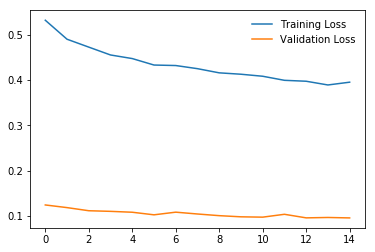

In [148]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
#plt.plot(test_losses, label = "Test Loss")
plt.legend(frameon=False)

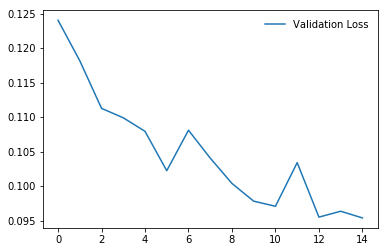

In [142]:
plt.plot(valid_losses, label = "Validation Loss")
plt.legend(frameon=False)

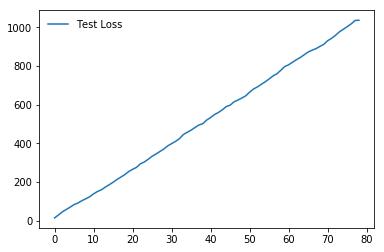

In [145]:
plt.plot(test_losses, label = "Test Loss")
plt.legend(frameon=False)

In [46]:
pred_data = datasets.ImageFolder('C:/Users/Henok/Pictures/cat/', transform=test_transform)
pred_loader = torch.utils.data.DataLoader(pred_data, batch_size=3)

In [47]:
image, label = next(iter(pred_loader))

In [48]:
p = model(image)
p = torch.exp(p)
p

tensor([[0.7966, 0.2034],
        [0.6899, 0.3101],
        [0.3300, 0.6700]], grad_fn=<ExpBackward>)

TypeError: floor(): argument 'input' (position 1) must be Tensor, not tuple

In [27]:
torch.save(model.state_dict(), 'C:/Users/Henok/Desktop/WEEK 1/Cats and Dogs/Model states/cat_and_dog_Classifier_model.pt')